In [1]:
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import joblib
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
#Paths for all datasets
path_train = 'datasets/train.csv'
path_client = 'datasets/client.csv'
path_gas_prices = 'datasets/gas_prices.csv'
path_forecast_weather = 'datasets/forecast_weather.csv'
path_weather_to_county = 'datasets/weather_station_to_county_mapping.csv'
path_electricity_prices = 'datasets/electricity_prices.csv'
path_historical_weather = 'datasets/historical_weather.csv'

In [3]:
train_df = pd.read_csv(
    path_train, 
    parse_dates=['datetime'])

fw_df = pd.read_csv(
    path_forecast_weather, 
    parse_dates=['forecast_datetime', "origin_datetime"])

hw_df = pd.read_csv(
    path_historical_weather, 
    parse_dates=['datetime'])

client_df = pd.read_csv(
    path_client,
    parse_dates=['date'])

gas_prices_df = pd.read_csv(
    path_gas_prices,
    parse_dates=['forecast_date'])

electricity_df = pd.read_csv(
    path_electricity_prices,
    parse_dates=['forecast_date'])

weather_station_to_county_mapping = pd.read_csv(path_weather_to_county)

In [4]:
historical_weather_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
                           'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
                           'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']

forecast_weather_cols = ['hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high',
                         'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component',
                         '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation',
                         'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']

In [5]:
# df creating date feature
train_df["date"] = train_df["datetime"].dt.date
train_df["date"] = pd.to_datetime(train_df["date"])

# merging train_df with client_df
df = (train_df
      .merge(
          client_df.drop(columns=["data_block_id"]),
          how="left",
          on=["county", "is_business", "product_type","date"]
          )
     )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88
...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN


In [6]:
# in gas_prices_df, drop origin_date and rename forecast_date
gas_prices_df = (gas_prices_df
                 .drop(columns=["origin_date"])
                 .rename(columns={"forecast_date": "date"})
                )

# merge gas_prices_df with df
df = (df
      .merge(
          gas_prices_df.drop(columns=["data_block_id"]),
          how="left", 
          on=["date"]
          )
      )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89,45.23,46.32
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89,45.23,46.32
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40,45.23,46.32
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40,45.23,46.32
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN,NaN,NaN


In [7]:
# electricity
electricity_df = (electricity_df
                  .drop(columns=["origin_date"])
                  .rename(columns={"forecast_date": "datetime"})
                  )

electricity_df["datetime"] = (pd.to_datetime(electricity_df["datetime"])
                              + pd.Timedelta(days=1)
                              )

electricity_df["euros_per_mwh"] = (electricity_df["euros_per_mwh"].abs() 
                                   + 0.1)

# merging df with electricity_df
df = (df
      .merge(
          electricity_df.drop(columns=["data_block_id"]),
          how="left",
          on=[ "datetime"]
          )
     )


df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89,45.23,46.32,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89,45.23,46.32,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40,45.23,46.32,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40,45.23,46.32,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88,45.23,46.32,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN,NaN,NaN,1.39


In [8]:
# fw_df 
fw_df["datetime"] = (pd.to_datetime(fw_df["origin_datetime"])
                     + pd.to_timedelta(fw_df["hours_ahead"], unit='h')
                     )

fw_df = (fw_df
         .assign(
             latitude=fw_df["latitude"].astype('float32').round(1),
             longitude=fw_df["longitude"].astype('float32').round(1),
             data_block_id=fw_df["data_block_id"].astype('int64')
             )
         )


fw_df

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,datetime
0,57.599998,21.700001,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
1,57.599998,22.200001,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
2,57.599998,22.700001,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
3,57.599998,23.200001,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
4,57.599998,23.700001,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.700001,26.200001,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424508,59.700001,26.700001,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424509,59.700001,27.200001,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424510,59.700001,27.700001,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00


In [9]:
weather_station_to_county_mapping = (weather_station_to_county_mapping
                                     .assign(
                                         latitude=weather_station_to_county_mapping["latitude"].astype('float32').round(1),
                                         longitude=weather_station_to_county_mapping["longitude"].astype('float32').round(1)
                                         )
                                     )


# merging weather forecast dataset with weather_station_to_county_mapping
fw_df = (fw_df
         .merge(
             weather_station_to_county_mapping.drop(columns=["county_name"]),
             how="left",
             on=["longitude", "latitude"]
             )
         .drop(columns=["longitude", "latitude", "origin_datetime"])
         )

fw_df

,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,datetime,county
0,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
1,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
2,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
3,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
4,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424508,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424509,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424510,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN


In [10]:
fw_df = (fw_df
         .groupby(["datetime", "data_block_id"])
         .agg({col: 'mean' for col in forecast_weather_cols})
         .reset_index()
         )

fw_df.columns = [f"fw_{col}" if col in forecast_weather_cols else col for col in fw_df.columns]

#fw_df["county"] = fw_df["county"].astype('int64')
fw_df = (fw_df
         .assign(
             data_block_id=fw_df["data_block_id"].astype('int64')
             )
         )


fw_df

,datetime,data_block_id,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,fw_cloudcover_low,fw_cloudcover_mid,fw_cloudcover_total,fw_10_metre_u_wind_component,fw_10_metre_v_wind_component,fw_forecast_datetime,fw_direct_solar_radiation,fw_surface_solar_radiation_downwards,fw_snowfall,fw_total_precipitation
0,2021-09-01 03:00:00,1,1.0,13.062975,10.690589,0.292374,0.183447,0.062130,0.440905,1.959828,-5.292196,2021-09-01 03:00:00,0.000000,0.000000,0.0,0.000000e+00
1,2021-09-01 04:00:00,1,2.0,12.963464,10.582913,0.271825,0.178160,0.082486,0.427419,2.135921,-5.392188,2021-09-01 04:00:00,0.000000,0.000000,0.0,8.141090e-07
2,2021-09-01 05:00:00,1,3.0,12.832809,10.455104,0.255049,0.153885,0.098480,0.408272,2.295792,-5.488858,2021-09-01 05:00:00,0.000000,0.000000,0.0,6.782689e-07
3,2021-09-01 06:00:00,1,4.0,12.867699,10.403001,0.271870,0.141209,0.100900,0.425778,2.414418,-5.532233,2021-09-01 06:00:00,55.961786,9.927205,0.0,1.333654e-06
4,2021-09-01 07:00:00,1,5.0,13.339924,10.518761,0.248376,0.122084,0.085374,0.378721,2.533944,-5.632845,2021-09-01 07:00:00,247.383901,81.928539,0.0,1.371439e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30571,2023-05-31 22:00:00,637,44.0,11.729009,5.960873,0.416247,0.020762,0.027475,0.456015,4.466787,-2.069000,2023-05-31 22:00:00,3.715556,0.413333,0.0,0.000000e+00
30572,2023-05-31 23:00:00,637,45.0,11.137857,5.725789,0.504970,0.016986,0.031082,0.526855,4.432824,-2.405810,2023-05-31 23:00:00,0.010794,0.000000,0.0,0.000000e+00
30573,2023-06-01 00:00:00,637,46.0,10.659773,5.493812,0.394751,0.016852,0.030581,0.397820,4.368315,-2.626136,2023-06-01 00:00:00,0.000000,0.000000,0.0,0.000000e+00
30574,2023-06-01 01:00:00,637,47.0,10.236302,5.293022,0.309380,0.021396,0.034688,0.317103,4.359639,-2.748081,2023-06-01 01:00:00,0.000000,0.000000,0.0,0.000000e+00


In [11]:
df = df.merge(
    fw_df, 
    how="left", 
    on=["datetime","data_block_id"]
    )

# Converting Celcius to Kelvin
df["fw_new_feature"] = (df["installed_capacity"]
                        * df["fw_surface_solar_radiation_downwards"]
                        / (df["fw_temperature"]+ 273.15)
                        )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,fw_cloudcover_mid,fw_cloudcover_total,fw_10_metre_u_wind_component,fw_10_metre_v_wind_component,fw_forecast_datetime,fw_direct_solar_radiation,fw_surface_solar_radiation_downwards,fw_snowfall,fw_total_precipitation,fw_new_feature
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN


In [12]:
# Convert 'datetime' column to datetime format and shift by one day
hw_df["datetime"] = pd.to_datetime(hw_df["datetime"]) + pd.Timedelta(days=1)

# 1- Convert 'latitude' and 'longitude' columns to float32 and round to 1 decimal place 
# 2- Convert 'data_block_id' column to int64
hw_df = (hw_df
         .assign(
             latitude=hw_df["latitude"].astype('float32').round(1),
             longitude=hw_df["longitude"].astype('float32').round(1),
             data_block_id=hw_df["data_block_id"].astype('int64')
             )
        )

# Merging hw_df (historical weather dataframe) with weather_station_to_county_mapping 
hw_df = (hw_df
         .merge(
             weather_station_to_county_mapping.drop(columns=["county_name"]),
             how="left",
             on=["longitude", "latitude"]
             )
         .drop(columns=["longitude", "latitude"])
         )

# Group by 'datetime' and 'data_block_id', calculating mean for historical weather columns
hw_df = (hw_df
         .groupby(["datetime", "data_block_id"])
         .agg({col: 'mean' for col in historical_weather_cols})
         .rename(columns={col: f"hw_{col}" for col in historical_weather_cols})
         .reset_index()
         )

# Reset index and adjust 'datetime' based on the hour

hw_df = (hw_df
         .assign(
             datetime=np.where(
                 hw_df["datetime"].dt.hour > 10,
                 hw_df["datetime"] + pd.Timedelta(days=1),
                 hw_df["datetime"]
                 ),
             data_block_id=hw_df["data_block_id"].astype('int64')
             )
         )


# Merge the processed historical weather DataFrame with the main DataFrame
df = df.merge(
    hw_df,
    how="left", 
    on=["datetime", "data_block_id"]
    )

In [13]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

In [14]:
df['season'] = df['datetime'].apply(get_season)

In [15]:
lags = [1,2,3,4,5,6]

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['target_lag_' + str(lag)] = dataframe.groupby(["prediction_unit_id","is_consumption"])['target'].transform(
            lambda x: x.shift(lag))
    return dataframe

In [16]:
df = lag_features(df,lags=lags)

In [17]:
df.dropna(subset=['target'], inplace=True)
df.set_index("datetime", drop=True)
df.drop(["date"],axis=1, inplace=True)
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,108.0,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,108.0,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,17.0,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,17.0,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,688.0,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,NaN,...,0.0,0.0,0.0,Spring,207.244,323.350,537.154,530.777,519.337,494.629
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,NaN,...,0.0,0.0,0.0,Spring,0.000,2.840,25.563,59.005,108.043,227.997
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,NaN,...,0.0,0.0,0.0,Spring,36.083,24.250,13.756,13.353,11.033,6.726
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,NaN,...,0.0,0.0,0.0,Spring,0.001,7.030,43.751,111.403,249.454,409.917


In [18]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [19]:
df_is_one = df[df["is_consumption"] == 1]
df_is_one.drop(columns="is_consumption", inplace=True)
df_is_one

C:\Users\MEHMET\AppData\Local\Temp\ipykernel_13972\3777614171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_is_one.drop(columns="is_consumption", inplace=True)


,county,is_business,product_type,target,datetime,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
1,0,0,1,96.590,2021-09-01 00:00:00,0,1,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,2021-09-01 00:00:00,0,3,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,3,656.859,2021-09-01 00:00:00,0,5,2,688.0,7207.88,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
7,0,1,0,59.000,2021-09-01 00:00:00,0,7,3,5.0,400.00,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
9,0,1,1,501.760,2021-09-01 00:00:00,0,9,4,43.0,1411.00,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018343,15,0,1,42.401,2023-05-31 23:00:00,637,2018343,57,NaN,NaN,...,0.0,0.0,0.0,Spring,63.068,52.427,35.140,27.369,19.446,11.577
2018345,15,0,3,117.332,2023-05-31 23:00:00,637,2018345,58,NaN,NaN,...,0.0,0.0,0.0,Spring,131.833,124.146,85.693,65.457,45.783,33.739
2018347,15,1,0,197.233,2023-05-31 23:00:00,637,2018347,64,NaN,NaN,...,0.0,0.0,0.0,Spring,207.244,323.350,537.154,530.777,519.337,494.629
2018349,15,1,1,28.404,2023-05-31 23:00:00,637,2018349,59,NaN,NaN,...,0.0,0.0,0.0,Spring,36.083,24.250,13.756,13.353,11.033,6.726


In [20]:
df_is_zero = df[df["is_consumption"] == 0]
df_is_zero.drop(columns="is_consumption", inplace=True)
df_is_zero

C:\Users\MEHMET\AppData\Local\Temp\ipykernel_13972\2590425055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_is_zero.drop(columns="is_consumption", inplace=True)


,county,is_business,product_type,target,datetime,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
0,0,0,1,0.713,2021-09-01 00:00:00,0,0,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,2021-09-01 00:00:00,0,2,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,2021-09-01 00:00:00,0,4,2,688.0,7207.88,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1,0,0.000,2021-09-01 00:00:00,0,6,3,5.0,400.00,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
8,0,1,1,0.000,2021-09-01 00:00:00,0,8,4,43.0,1411.00,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018342,15,0,1,0.004,2023-05-31 23:00:00,637,2018342,57,NaN,NaN,...,0.0,0.0,0.0,Spring,0.005,1.804,19.584,26.074,54.892,108.509
2018344,15,0,3,2.287,2023-05-31 23:00:00,637,2018344,58,NaN,NaN,...,0.0,0.0,0.0,Spring,2.545,6.982,43.101,124.516,259.333,551.754
2018346,15,1,0,0.000,2023-05-31 23:00:00,637,2018346,64,NaN,NaN,...,0.0,0.0,0.0,Spring,0.000,1.260,8.649,20.147,36.280,91.863
2018348,15,1,1,0.000,2023-05-31 23:00:00,637,2018348,59,NaN,NaN,...,0.0,0.0,0.0,Spring,0.000,2.840,25.563,59.005,108.043,227.997


In [21]:
df_is_one = one_hot_encoder(df_is_one, ['county', 'is_business', 'product_type', "prediction_unit_id","season"])

In [22]:
df_is_zero = one_hot_encoder(df_is_zero, ['county', 'is_business', 'product_type', "prediction_unit_id","season"])

In [23]:
df_is_one

,target,datetime,data_block_id,row_id,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,...,prediction_unit_id_62,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter
1,96.590,2021-09-01 00:00:00,0,1,108.0,952.89,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,17.314,2021-09-01 00:00:00,0,3,17.0,166.40,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
5,656.859,2021-09-01 00:00:00,0,5,688.0,7207.88,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
7,59.000,2021-09-01 00:00:00,0,7,5.0,400.00,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
9,501.760,2021-09-01 00:00:00,0,9,43.0,1411.00,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018343,42.401,2023-05-31 23:00:00,637,2018343,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False
2018345,117.332,2023-05-31 23:00:00,637,2018345,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False
2018347,197.233,2023-05-31 23:00:00,637,2018347,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,True,False,False,False,False,True,False,False
2018349,28.404,2023-05-31 23:00:00,637,2018349,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False


In [24]:
df_is_zero

,target,datetime,data_block_id,row_id,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,...,prediction_unit_id_62,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter
0,0.713,2021-09-01 00:00:00,0,0,108.0,952.89,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,0.000,2021-09-01 00:00:00,0,2,17.0,166.40,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,2.904,2021-09-01 00:00:00,0,4,688.0,7207.88,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
6,0.000,2021-09-01 00:00:00,0,6,5.0,400.00,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
8,0.000,2021-09-01 00:00:00,0,8,43.0,1411.00,45.23,46.32,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018342,0.004,2023-05-31 23:00:00,637,2018342,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False
2018344,2.287,2023-05-31 23:00:00,637,2018344,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False
2018346,0.000,2023-05-31 23:00:00,637,2018346,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,True,False,False,False,False,True,False,False
2018348,0.000,2023-05-31 23:00:00,637,2018348,NaN,NaN,NaN,NaN,1.39,45.0,...,False,False,False,False,False,False,False,True,False,False


In [25]:
df_is_one.drop(columns="row_id", axis=1, inplace=True)
df_is_zero.drop(columns="row_id", axis=1, inplace=True)

In [26]:
train_zero = df_is_zero[df_is_zero["data_block_id"] <= 500]
test_zero = df_is_zero[df_is_zero["data_block_id"] > 500]

In [27]:
train_zero.drop(columns="data_block_id", inplace=True) 
test_zero.drop(columns="data_block_id", inplace=True) 

C:\Users\MEHMET\AppData\Local\Temp\ipykernel_13972\3031238331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_zero.drop(columns="data_block_id", inplace=True)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_13972\3031238331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_zero.drop(columns="data_block_id", inplace=True)


In [28]:
y_train_zero = train_zero["target"]
X_train_zero = train_zero.drop("target", axis=1)
y_test_zero = test_zero["target"]
X_test_zero = test_zero.drop("target", axis=1)

X_train_zero = X_train_zero.select_dtypes(exclude=['datetime64[ns]'])
X_test_zero = X_test_zero.select_dtypes(exclude=['datetime64[ns]'])

In [29]:
train_one = df_is_one[df_is_one["data_block_id"] <= 500].select_dtypes(exclude=['datetime64[ns]'])
test_one = df_is_one[df_is_one["data_block_id"] > 500].select_dtypes(exclude=['datetime64[ns]'])

In [30]:
train_one.drop(columns="data_block_id", inplace=True) 
test_one.drop(columns="data_block_id", inplace=True) 

In [31]:
y_train_one = train_one["target"]
X_train_one = train_one.drop("target", axis=1)
y_test_one = test_one["target"]
X_test_one = test_one.drop("target", axis=1)


In [32]:
lgbm_model = LGBMRegressor()

lgbm_random={'subsample_for_bin': 345895,
             'num_leaves': 63,
             'n_estimators': 5227,
             'min_split_gain': 0.12083725162852055,
             'min_child_weight': 0.03807974066189634,
             'min_child_samples': 49,
             'learning_rate': 0.08685740003902279,
             'colsample_bytree': 0.7722564662082128}

In [33]:
lgbm_final_zero = lgbm_model.set_params(**lgbm_random, random_state=42).fit(X_train_zero,y_train_zero)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9866
[LightGBM] [Info] Number of data points in the train set: 791106, number of used features: 129
[LightGBM] [Info] Start training from score 73.014501


In [34]:
test_pred_zero = lgbm_final_zero.predict(X_test_zero)

In [35]:
print(mean_absolute_error(y_test_zero,test_pred_zero))

32.19460611075163


In [36]:
lgbm_final_one = lgbm_model.set_params(**lgbm_random, random_state=42).fit(X_train_one,y_train_one)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9866
[LightGBM] [Info] Number of data points in the train set: 791106, number of used features: 129
[LightGBM] [Info] Start training from score 441.771878


In [37]:
test_pred_one = lgbm_final_one.predict(X_test_one)

In [38]:
print(mean_absolute_error(y_test_one,test_pred_one))

42.02999561868598


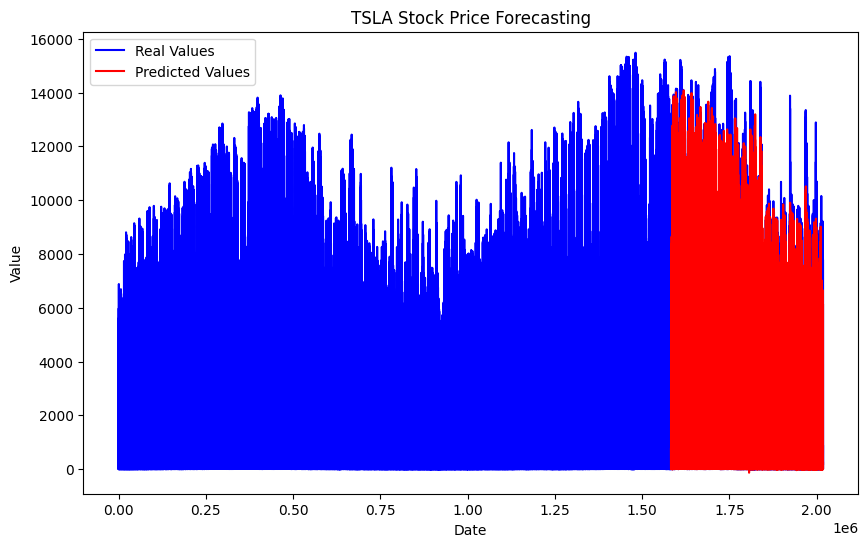

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df_is_one.index, df_is_one['target'], label='Real Values', color='blue')
plt.plot(X_test_one.index, test_pred_one, label='Predicted Values', color='red')
plt.title('TSLA Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

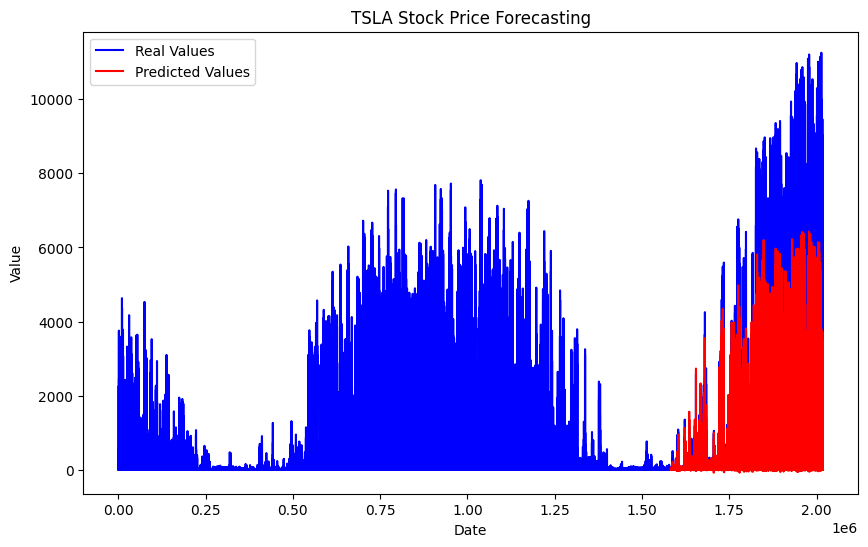

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(df_is_zero.index, df_is_zero['target'], label='Real Values', color='blue')
plt.plot(X_test_zero.index, test_pred_zero, label='Predicted Values', color='red')
plt.title('TSLA Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [48]:
with open('model_for_zero.pkl', 'wb') as f:
    pickle.dump(lgbm_final_zero, f)

In [49]:
with open('model_for_one.pkl', 'wb') as f:
    pickle.dump(lgbm_final_one, f)